In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy
from collections import Counter
import dowhy
from dowhy import CausalModel
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [54]:
chosen_AC_Path = r"E:\UIC\Fall24\Causal Learning\chosen_AC.npy"
chosen_AR_Path = r"E:\UIC\Fall24\Causal Learning\chosen_AR.npy"
chosen_NC_Path = r"E:\UIC\Fall24\Causal Learning\chosen_NC.npy"

reco_AC_Path = r"E:\UIC\Fall24\Causal Learning\recommendations_AC.npy"
reco_AR_Path = r"E:\UIC\Fall24\Causal Learning\recommendations_AR.npy"
reco_NC_Path = r"E:\UIC\Fall24\Causal Learning\recommendations_NC.npy"

score_AC_Path = r"E:\UIC\Fall24\Causal Learning\score_AC.npy"
score_AR_Path = r"E:\UIC\Fall24\Causal Learning\score_AR.npy"
score_NC_Path = r"E:\UIC\Fall24\Causal Learning\score_NC.npy"

In [55]:
chosen_AC = np.load(chosen_AC_Path)
reco_AC = np.load(reco_AC_Path)
score_AC = np.load(score_AC_Path)

chosen_AR = np.load(chosen_AR_Path)
reco_AR = np.load(reco_AR_Path)
score_AR = np.load(score_AR_Path)

chosen_NC = np.load(chosen_NC_Path)
reco_NC = np.load(reco_NC_Path)
score_NC = np.load(score_NC_Path)

In [56]:
timesteps, num_agents = chosen_AC.shape

In [57]:
scores_AC_array = np.array(score_AC).reshape((timesteps, num_agents))
scores_AR_array = np.array(score_AR).reshape((timesteps, num_agents))
scores_NC_array = np.array(score_NC).reshape((timesteps, num_agents))

In [58]:
data_list = []

In [59]:
for t in range(timesteps):
    for agent in range(num_agents):
        data_list.append({
            'user_id': agent,
            'timestep': t,
            'algorithm_type': 1,  # Collaborative filtering
            'homogeneity_score': scores_AC_array[t, agent],
            'user_choice': chosen_AC[t, agent],
            'method': 'AC'
        })

In [60]:
for t in range(timesteps):
    for agent in range(num_agents):
        data_list.append({
            'user_id': agent,
            'timestep': t,
            'algorithm_type': 1,  # Collaborative filtering
            'homogeneity_score': scores_AR_array[t, agent],
            'user_choice': chosen_AR[t, agent],
            'method': 'AR'
        })

In [61]:
for t in range(timesteps):
    for agent in range(num_agents):
        data_list.append({
            'user_id': agent,
            'timestep': t,
            'algorithm_type': 0,  # Random recommendations
            'homogeneity_score': scores_NC_array[t, agent],
            'user_choice': chosen_NC[t, agent],
            'method': 'NC'
        })

In [62]:
df = pd.DataFrame(data_list)

In [63]:
df.head()

,user_id,timestep,algorithm_type,homogeneity_score,user_choice,method
0,0,0,1,9.899778,22,AC
1,1,0,1,412.768842,3105,AC
2,2,0,1,350.961853,628,AC
3,3,0,1,284.003283,3769,AC
4,4,0,1,416.574402,14,AC


In [64]:
movies = pd.read_csv(r"E:\UIC\Fall24\Causal Learning\movies.csv")

In [65]:
movies_expanded = movies.copy()
movies_expanded['genres'] = movies_expanded['genres'].str.split('|')
movies_expanded = movies_expanded.explode('genres')

In [66]:
movie_genres = movies_expanded.groupby('movieId')['genres'].apply(list).to_dict()

In [67]:
def get_genres(movie_ids):
    genres = []
    for movie_id in movie_ids:
        genres.extend(movie_genres.get(movie_id, []))
    return genres

In [68]:
df['recommended_genres'] = df['method'].apply(lambda x: [] )  # Initialize empty lists

In [69]:
df['chosen_genres'] = df['user_choice'].apply(lambda x: movie_genres.get(x, []))

In [70]:
def get_all_recommended_genres(recommendations):
    genres = []
    for rec in recommendations:
        genres.extend(movie_genres.get(rec, []))
    return genres

In [73]:
df['recommended_genres'] = df.apply(lambda row: get_all_recommended_genres(reco_AC[row['timestep'], row['user_id']]) if row['method']=='AC' else 
                                              get_all_recommended_genres(reco_AR[row['timestep'], row['user_id']]) if row['method']=='AR' else 
                                              get_all_recommended_genres(reco_NC[row['timestep'], row['user_id']]), axis=1)

In [74]:
def compute_genre_diversity(genres):
    if not genres:
        return 0
    genre_counts = Counter(genres)
    diversity = len(genre_counts)  # Simple count of unique genres
    return diversity

In [75]:
df['genre_diversity'] = df['recommended_genres'].apply(compute_genre_diversity)

In [76]:
def compute_entropy_diversity(genres):
    if not genres:
        return 0
    genre_counts = Counter(genres)
    total = sum(genre_counts.values())
    probabilities = [count / total for count in genre_counts.values()]
    ent = entropy(probabilities, base=2)  # Using base 2 for bits
    return ent

In [77]:
df['entropy_diversity'] = df['recommended_genres'].apply(compute_entropy_diversity)

In [78]:
coverage = df.groupby('method')['user_choice'].nunique() / df['user_choice'].nunique()
print("Coverage per Method:")
print(coverage)

Coverage per Method:
method
AC    0.091954
AR    0.367816
NC    0.574713
Name: user_choice, dtype: float64


In [79]:
genre_coverage = {}
for method in df['method'].unique():
    genres = df[df['method'] == method]['recommended_genres'].explode().dropna().unique()
    genre_coverage[method] = len(genres) / len(set(movies_expanded['genres']))

In [80]:
print("\nGenre Coverage per Method:")
for method, coverage_score in genre_coverage.items():
    print(f"{method}: {coverage_score:.2f}")


Genre Coverage per Method:
AC: 0.75
AR: 0.80
NC: 0.95


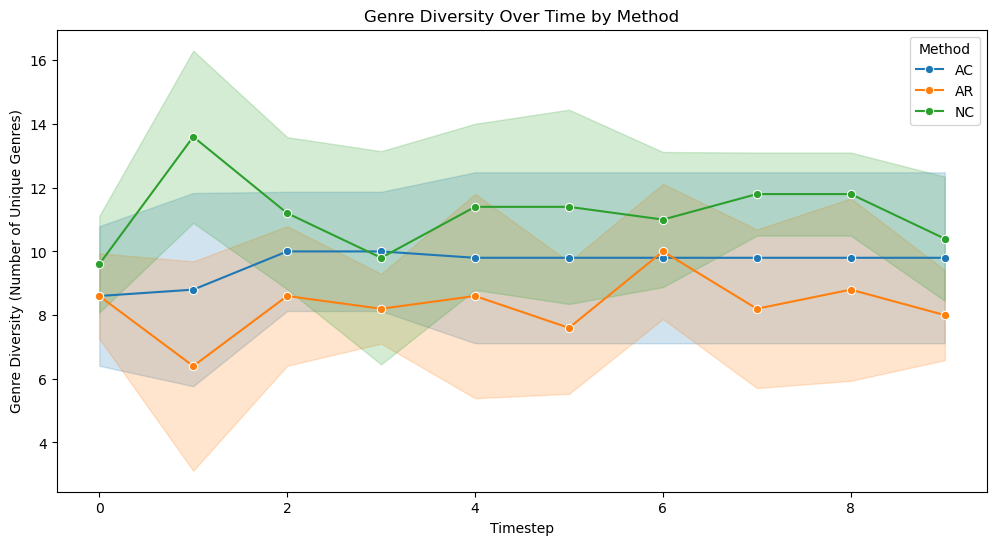

In [81]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestep', y='genre_diversity', hue='method', ci='sd', marker='o')
plt.title('Genre Diversity Over Time by Method')
plt.xlabel('Timestep')
plt.ylabel('Genre Diversity (Number of Unique Genres)')
plt.legend(title='Method')
plt.show()

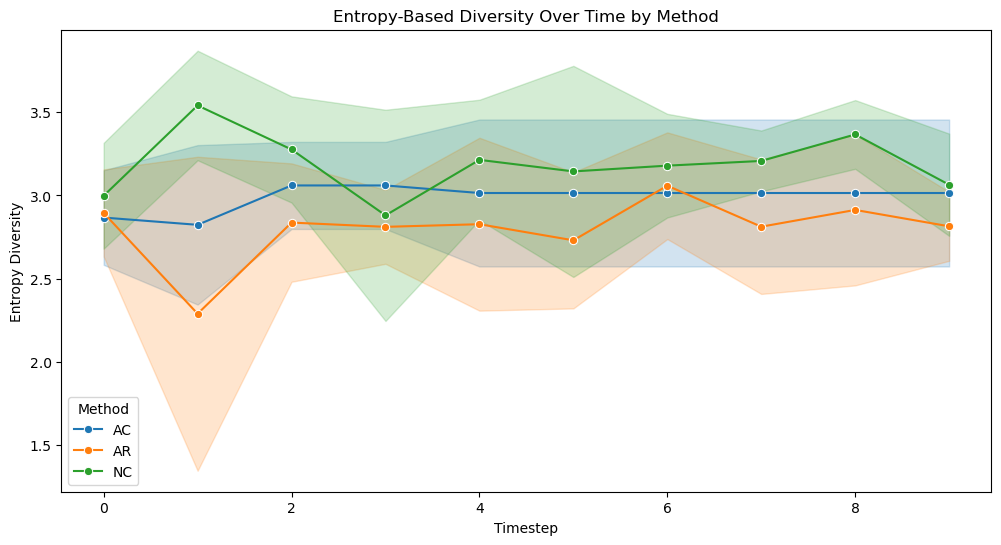

In [82]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestep', y='entropy_diversity', hue='method', ci='sd', marker='o')
plt.title('Entropy-Based Diversity Over Time by Method')
plt.xlabel('Timestep')
plt.ylabel('Entropy Diversity')
plt.legend(title='Method')
plt.show()

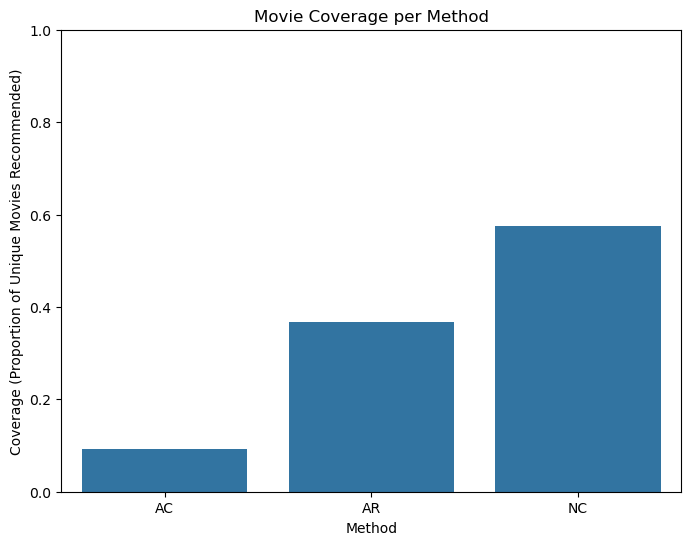

In [127]:
plt.figure(figsize=(8, 6))
sns.barplot(x=coverage.index, y=coverage.values)
plt.title('Movie Coverage per Method')
plt.xlabel('Method')
plt.ylabel('Coverage (Proportion of Unique Movies Recommended)')
plt.ylim(0, 1)
plt.show()

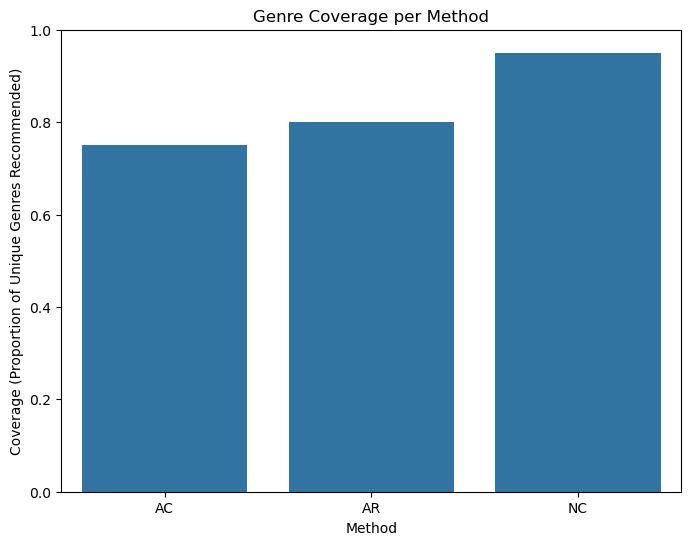

In [128]:
plt.figure(figsize=(8, 6))
methods = list(genre_coverage.keys())
scores = list(genre_coverage.values())
sns.barplot(x=methods, y=scores)
plt.title('Genre Coverage per Method')
plt.xlabel('Method')
plt.ylabel('Coverage (Proportion of Unique Genres Recommended)')
plt.ylim(0, 1)
plt.show()

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             150 non-null    int64  
 1   timestep            150 non-null    int64  
 2   algorithm_type      150 non-null    int64  
 3   homogeneity_score   150 non-null    float64
 4   user_choice         150 non-null    int64  
 5   method              150 non-null    object 
 6   recommended_genres  150 non-null    object 
 7   chosen_genres       150 non-null    object 
 8   genre_diversity     150 non-null    int64  
 9   entropy_diversity   150 non-null    float64
dtypes: float64(2), int64(5), object(3)
memory usage: 11.8+ KB


In [156]:
user_analysis = df.groupby(['method', 'user_id']).agg({
    'homogeneity_score': 'mean',
    'genre_diversity': 'mean',
    'entropy_diversity': 'mean'
}).reset_index()

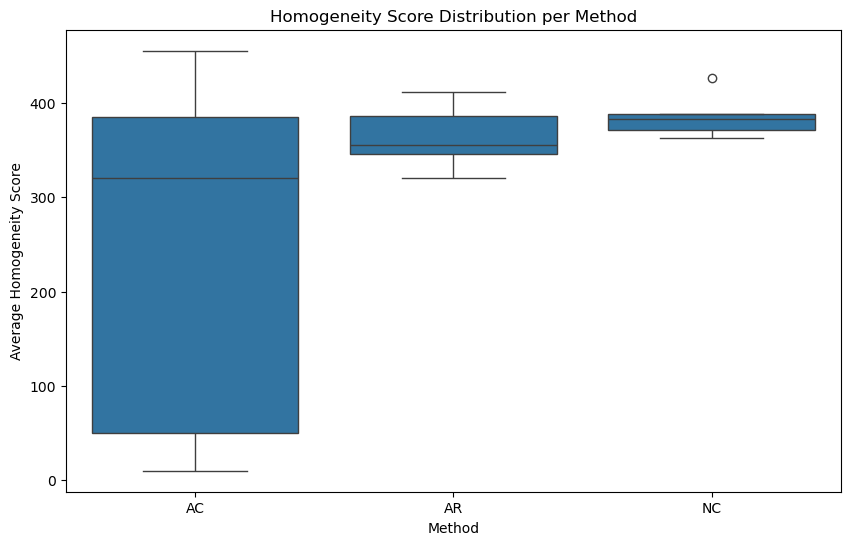

In [157]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_analysis, x='method', y='homogeneity_score')
plt.title('Homogeneity Score Distribution per Method')
plt.xlabel('Method')
plt.ylabel('Average Homogeneity Score')
plt.show()

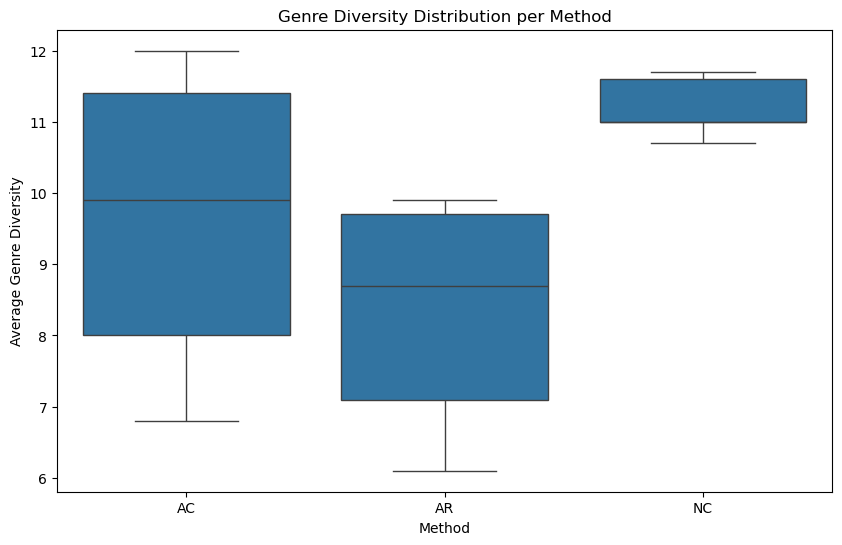

In [158]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_analysis, x='method', y='genre_diversity')
plt.title('Genre Diversity Distribution per Method')
plt.xlabel('Method')
plt.ylabel('Average Genre Diversity')
plt.show()

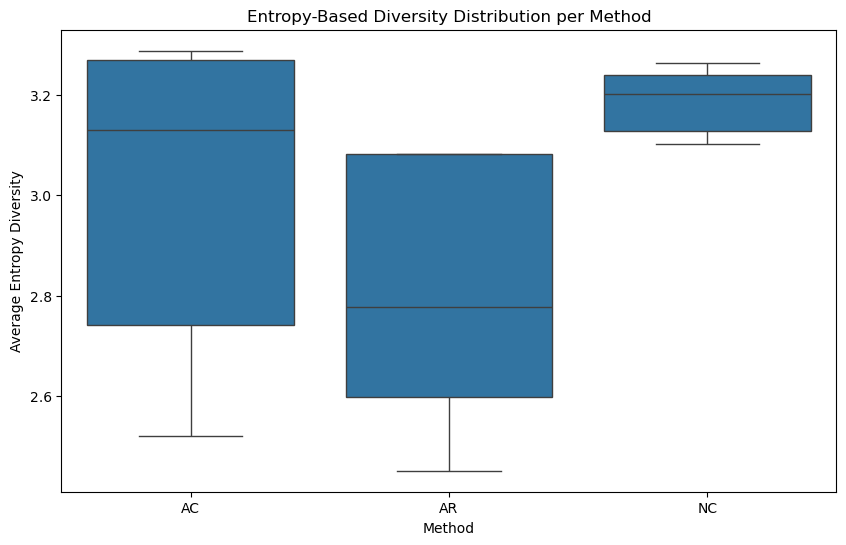

In [159]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_analysis, x='method', y='entropy_diversity')
plt.title('Entropy-Based Diversity Distribution per Method')
plt.xlabel('Method')
plt.ylabel('Average Entropy Diversity')
plt.show()

In [115]:
fvalue_div, pvalue_div = stats.f_oneway(
    df[df['method'] == 'AC']['genre_diversity'],
    df[df['method'] == 'AR']['genre_diversity'],
    df[df['method'] == 'NC']['genre_diversity']
)
print(f"ANOVA for Genre Diversity: F-value={fvalue_div:.2f}, p-value={pvalue_div:.4f}")

ANOVA for Genre Diversity: F-value=19.41, p-value=0.0000


In [90]:
fvalue_ent, pvalue_ent = stats.f_oneway(
    df[df['method'] == 'AC']['entropy_diversity'],
    df[df['method'] == 'AR']['entropy_diversity'],
    df[df['method'] == 'NC']['entropy_diversity']
)
print(f"ANOVA for Entropy Diversity: F-value={fvalue_ent:.2f}, p-value={pvalue_ent:.4f}")

ANOVA for Entropy Diversity: F-value=11.31, p-value=0.0000


In [91]:
if pvalue_div < 0.05:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey_div = pairwise_tukeyhsd(endog=df['genre_diversity'], groups=df['method'], alpha=0.05)
    print("\nTukey HSD for Genre Diversity:")
    print(tukey_div.summary())


Tukey HSD for Genre Diversity:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    AC     AR    -1.32 0.0145 -2.4235 -0.2165   True
    AC     NC     1.58 0.0026  0.4765  2.6835   True
    AR     NC      2.9    0.0  1.7965  4.0035   True
----------------------------------------------------


In [92]:
if pvalue_ent < 0.05:
    tukey_ent = pairwise_tukeyhsd(endog=df['entropy_diversity'], groups=df['method'], alpha=0.05)
    print("\nTukey HSD for Entropy Diversity:")
    print(tukey_ent.summary())


Tukey HSD for Entropy Diversity:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    AC     AR  -0.1911 0.0535 -0.3846 0.0023  False
    AC     NC   0.1973 0.0444  0.0039 0.3907   True
    AR     NC   0.3885    0.0  0.1951 0.5819   True
---------------------------------------------------


In [93]:
causal_df = df.copy()
causal_df['algorithm_type'] = causal_df['algorithm_type'].astype(int)
causal_df['homogeneity_score'] = causal_df['homogeneity_score'].astype(float)
causal_df['genre_diversity'] = causal_df['genre_diversity'].astype(float)
causal_df['entropy_diversity'] = causal_df['entropy_diversity'].astype(float)
causal_df['user_choice'] = causal_df['user_choice'].astype(int)

In [94]:
model = CausalModel(
    data=causal_df,
    treatment='algorithm_type',
    outcome='homogeneity_score',
    common_causes=['user_id', 'timestep'],
    instruments=None,
    effect_modifiers=None
)

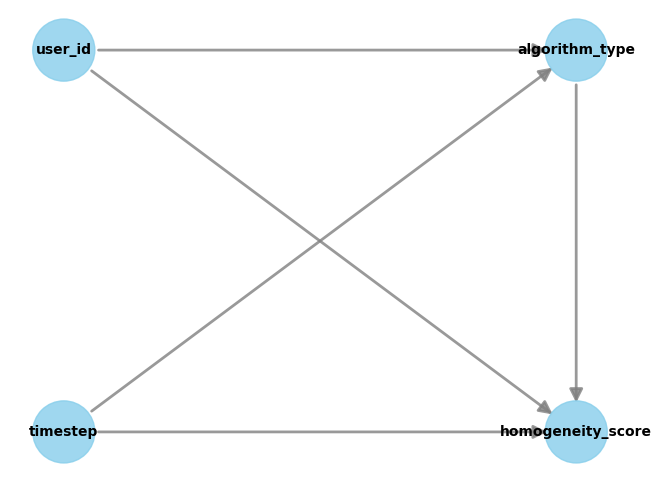

In [95]:
model.view_model()
plt.show()

In [96]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
─────────────────(E[homogeneity_score|timestep,user_id])
d[algorithm_type]                                       
Estimand assumption 1, Unconfoundedness: If U→{algorithm_type} and U→homogeneity_score then P(homogeneity_score|algorithm_type,timestep,user_id,U) = P(homogeneity_score|algorithm_type,timestep,user_id)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [97]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)
print("\nCausal Estimate:")
print(estimate)


Causal Estimate:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
─────────────────(E[homogeneity_score|timestep,user_id])
d[algorithm_type]                                       
Estimand assumption 1, Unconfoundedness: If U→{algorithm_type} and U→homogeneity_score then P(homogeneity_score|algorithm_type,timestep,user_id,U) = P(homogeneity_score|algorithm_type,timestep,user_id)

## Realized estimand
b: homogeneity_score~algorithm_type+timestep+user_id
Target units: ate

## Estimate
Mean value: -82.20051859302458
p-value: [0.00064653]



In [98]:
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print("\nRefutation Results:")
print(refute_results)


Refutation Results:
Refute: Add a random common cause
Estimated effect:-82.20051859302458
New effect:-82.4219458252751
p value:0.86



In [99]:
refute_results_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)
print("\nPlacebo Treatment Refutation Results:")
print(refute_results_placebo)


Placebo Treatment Refutation Results:
Refute: Use a Placebo Treatment
Estimated effect:-82.20051859302458
New effect:0.8012913766855564
p value:0.98



In [102]:
model_mediation = CausalModel(
    data=causal_df,
    treatment='algorithm_type',
    outcome='homogeneity_score',
    common_causes=['user_id', 'timestep'],
    mediators=['genre_diversity', 'entropy_diversity']
)

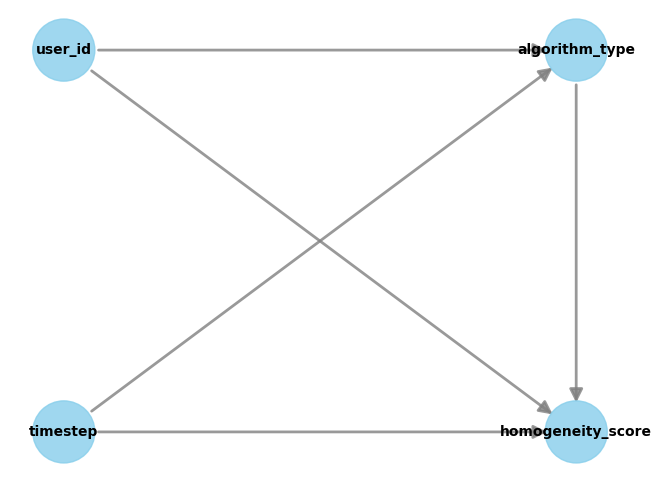

In [103]:
model_mediation.view_model()
plt.show()

In [104]:
identified_estimand_mediation = model_mediation.identify_effect()

In [105]:
estimate_direct = model_mediation.estimate_effect(
    identified_estimand_mediation,
    method_name="backdoor.linear_regression",
    control_value=0,
    treatment_value=1
)

In [106]:
estimate_total = model_mediation.estimate_effect(
    identified_estimand_mediation,
    method_name="backdoor.linear_regression",
    control_value=0,
    treatment_value=1
)

In [107]:
print("\nDirect Causal Effect (Algorithm Type -> Homogeneity Score):")
print(estimate_direct)

print("\nTotal Causal Effect (Algorithm Type -> Homogeneity Score):")
print(estimate_total)


Direct Causal Effect (Algorithm Type -> Homogeneity Score):
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                               
─────────────────(E[homogeneity_score|timestep,user_id])
d[algorithm_type]                                       
Estimand assumption 1, Unconfoundedness: If U→{algorithm_type} and U→homogeneity_score then P(homogeneity_score|algorithm_type,timestep,user_id,U) = P(homogeneity_score|algorithm_type,timestep,user_id)

## Realized estimand
b: homogeneity_score~algorithm_type+timestep+user_id
Target units: ate

## Estimate
Mean value: -82.20051859302458


Total Causal Effect (Algorithm Type -> Homogeneity Score):
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                             

In [108]:
corr_matrix = df[['homogeneity_score', 'genre_diversity', 'entropy_diversity']].corr()

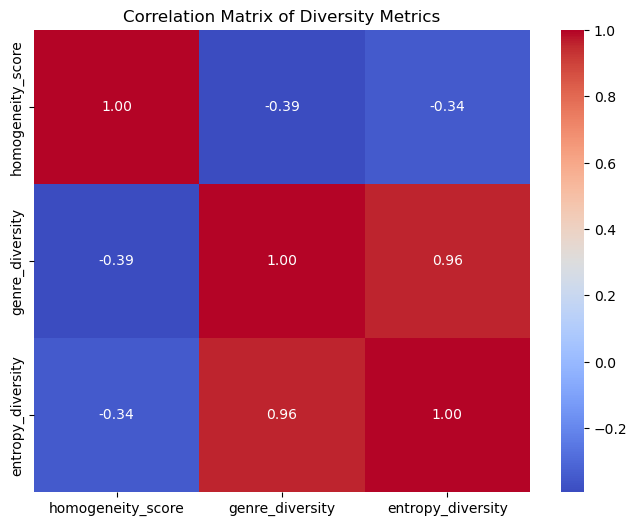

In [109]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Diversity Metrics')
plt.show()

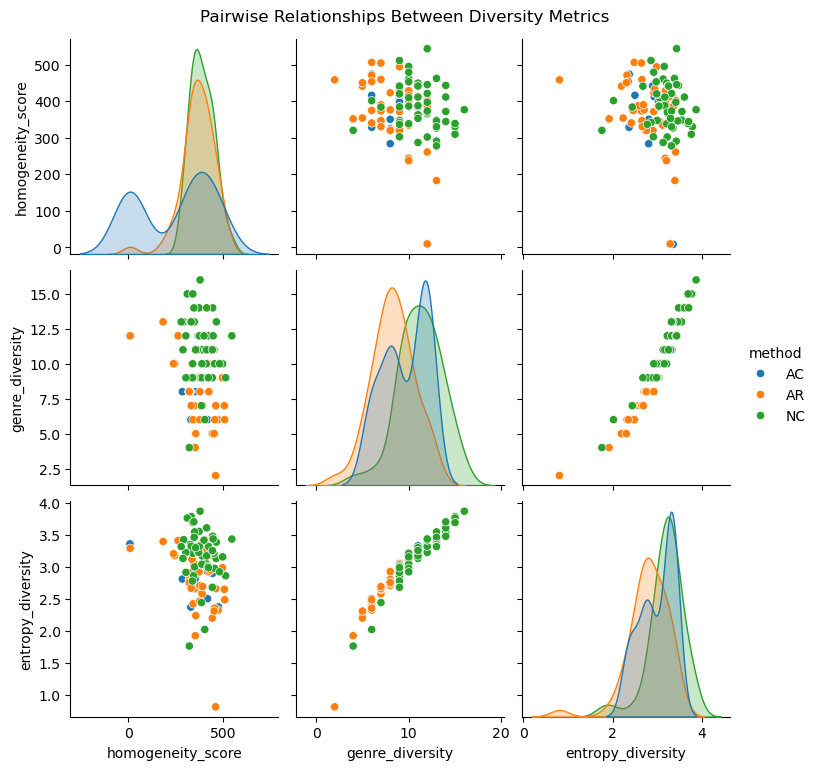

In [110]:
sns.pairplot(df, vars=['homogeneity_score', 'genre_diversity', 'entropy_diversity'], hue='method', diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Diversity Metrics', y=1.02)
plt.show()

In [111]:
summary_stats = df.groupby('method').agg({
    'homogeneity_score': ['mean', 'median', 'std', 'min', 'max'],
    'genre_diversity': ['mean', 'median', 'std', 'min', 'max'],
    'entropy_diversity': ['mean', 'median', 'std', 'min', 'max']
}).reset_index()

print("Summary Statistics per Method:")
print(summary_stats)

Summary Statistics per Method:
  method homogeneity_score                                                  \
                      mean      median         std         min         max   
0     AC        244.097793  324.733153  191.665587    8.717730  474.046969   
1     AR        364.011405  373.232666   87.245219    9.899778  506.734786   
2     NC        386.255118  380.733372   61.490562  278.061640  544.161521   

  genre_diversity                          entropy_diversity            \
             mean median       std min max              mean    median   
0            9.62   10.0  2.337712   6  12          2.989604  3.157425   
1            8.30    8.0  2.279008   2  13          2.798462  2.755911   
2           11.20   11.0  2.373321   4  16          3.186934  3.229178   

                                 
        std       min       max  
0  0.371313  2.368523  3.355389  
1  0.454902  0.811278  3.419382  
2  0.394582  1.760495  3.866729  
